### Uncertainty Prediction House Prices

In this notebook it is applied MDN to Boston house price dataset. We would like to compare this method with the technique proposed in Experiment 1.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
tf.enable_eager_execution()
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.datasets import load_boston
from utilities import bdl_techniques

In [2]:
boston_dataset = load_boston()

In [3]:
boston_dataset.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [4]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
boston['MEDV'] = boston_dataset.target

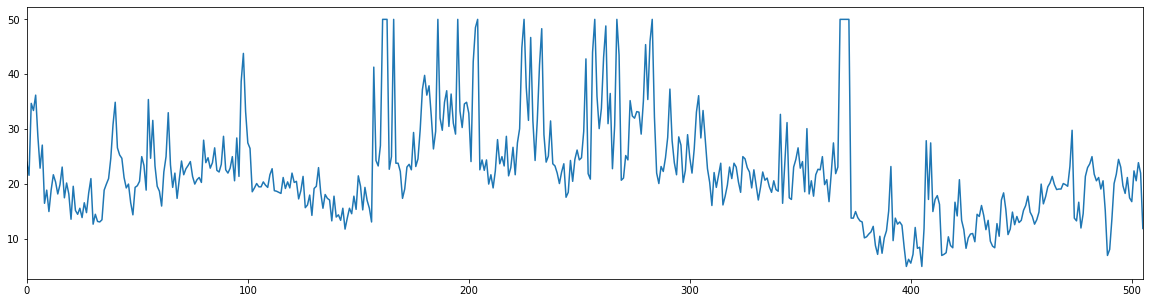

In [7]:
boston['MEDV'].plot(figsize=(20, 5))

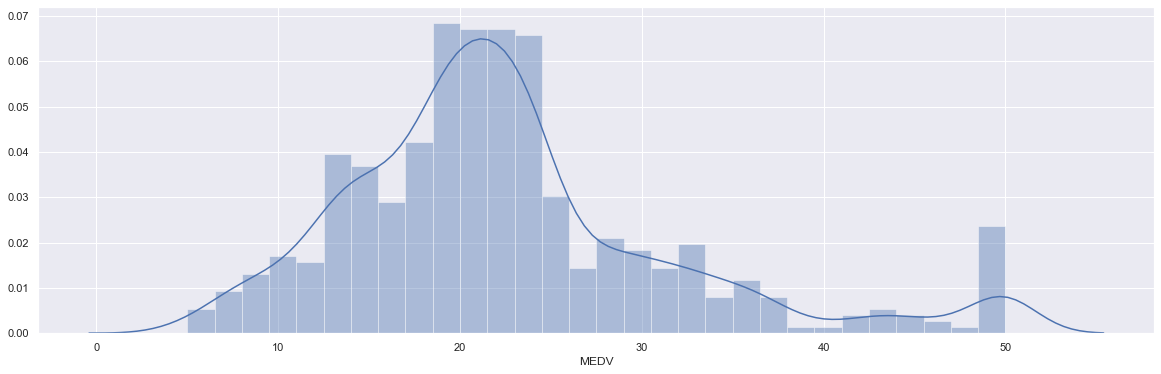

In [8]:
sns.set(rc={'figure.figsize':(20,6)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

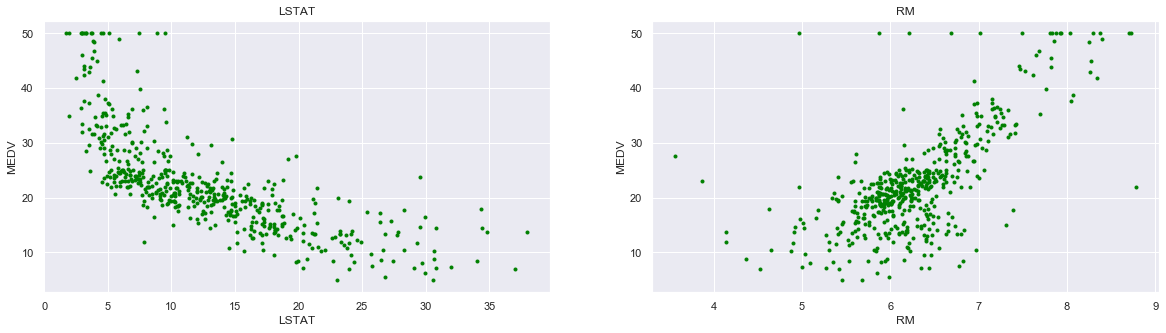

In [9]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.plot(x, y, '.', color= 'green')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

### Prepare data for training

#### Build vectors with the response target variable and sigma

In [10]:
boston['MEDV'].size, boston['LSTAT'].size

(506, 506)

In [103]:
# Add in column of dummy zeros to represent sigma 
#sigma = np.zeros(boston['MEDV'].size)
Y = pd.DataFrame(np.array([boston['MEDV']]).T, columns = ['y'])
X = pd.DataFrame(np.array([boston['LSTAT'], boston['RM']]).T, columns = ['LSTAT','RM'])

In [104]:
Y.tail()

,y
501,22.4
502,20.6
503,23.9
504,22.0
505,11.9


In [105]:
# Split into training and validation sets
from sklearn.model_selection import train_test_split
x, x_val, y, y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [106]:
x_train, x_val, y_train, y_val = x.values, x_val.values, y.values, y_val.values

In [107]:
y_train.size, x_train.size, x_val.size, y_val.size

(404, 808, 204, 102)

<Figure size 1008x432 with 0 Axes>

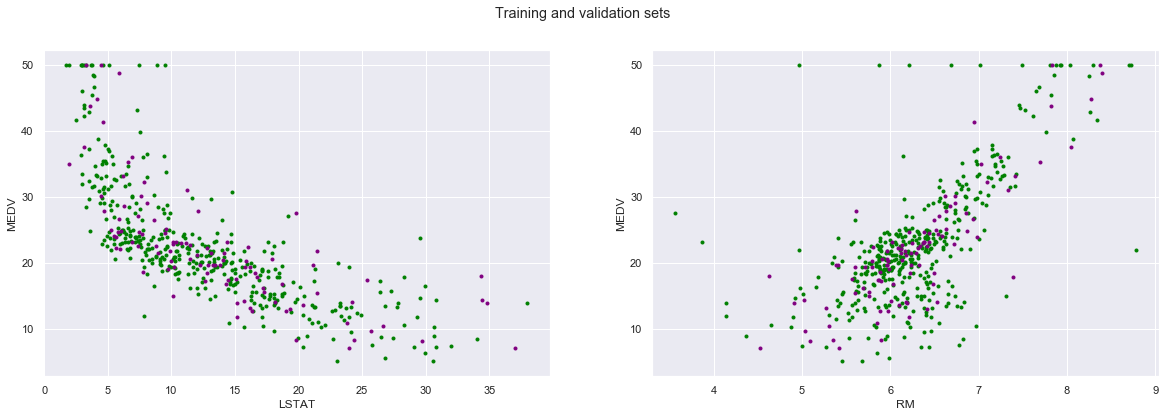

In [108]:
# Plot the data
plt.figure(figsize=(14,6))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Training and validation sets')
ax1.plot(x_train[:,0], y_train, '.', color= 'green')
ax1.plot(x_val[:,0], y_val, '.', color='purple')
ax1.set(xlabel='LSTAT', ylabel='MEDV');
ax2.plot(x_train[:,1], y_train, '.', color= 'green')
ax2.plot(x_val[:,1], y_val, '.', color='purple')
ax2.set(xlabel='RM', ylabel='MEDV');

### Experiment

### Create the MDN

In [109]:
no_parameters = 3
components = 1
neurons = 200
opt = tf.train.AdamOptimizer(1e-3)

tf_path = os.path.join(os.getcwd(), 'tf_board')
tensorboard = TensorBoard(log_dir=tf_path, histogram_freq=0, write_graph=True, write_images=False)
mon = EarlyStopping(monitor='val_loss', min_delta=0.0000001, patience=2, verbose=0, mode='auto')

In [110]:
mdn_ = bdl_techniques.MDN(neurons=neurons, components=components, no_parameters=no_parameters)
mdn_.compile(loss=mdn_.gnll_loss, optimizer=opt)

### Train the MDN

In [111]:
%%time
mdn_.fit(x=x_train, y=y_train, epochs=10000, validation_data=(x_val, y_val), batch_size=128, verbose=0)

Wall time: 3min 42s


#### Get predictions for validation set

In [112]:
from tensorflow_probability import distributions as tfd
alpha, mu, sigma = mdn_.slice_parameter_vectors(mdn_.predict([x_val]))

In [113]:
alpha.shape, mu.shape, sigma.shape, pyx.shape, x_val.shape, y_val.shape

((102, 1),
 (102, 1),
 (102, 1),
 TensorShape([Dimension(102)]),
 (102, 2),
 (102, 1))

#### Plot results

<Figure size 1008x432 with 0 Axes>

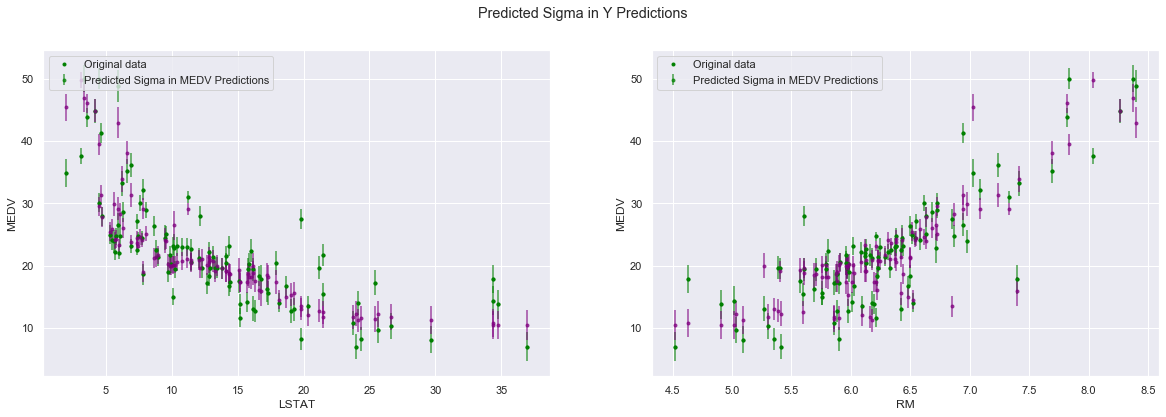

In [120]:
import warnings
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

# Plot predictions and their errors
plt.figure(figsize=(14,6))
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Predicted Sigma in Y Predictions')
ax1.plot(x_val[:,0], y_val[:,0], '.', color='green')
ax1.errorbar(x_val[:,0], y_val[:,0], yerr=np.sqrt(abs(sigma[:,0])), alpha=0.7, color='green', fmt='.'); 
ax1.errorbar(x_val[:,0], mu, yerr=np.sqrt(abs(sigma)) ,  alpha=0.7,color='purple', fmt='.'); 
ax1.set_xlabel(r'LSTAT');
ax1.set_ylabel(r'MEDV');
ax1.legend([r'Original data', 'Predicted Sigma in MEDV Predictions'], loc='upper left', );

ax2.plot(x_val[:,1], y_val[:,0], '.', color='green')
ax2.errorbar(x_val[:,1], y_val[:,0], yerr=np.sqrt(abs(sigma)), alpha=0.7, color='green', fmt='.'); 
ax2.errorbar(x_val[:,1], mu, yerr=np.sqrt(abs(sigma)), alpha=0.7, color='purple', fmt='.'); 
ax2.set_xlabel(r'RM');
ax2.set_ylabel(r'MEDV');
ax2.legend([r'Original data','Predicted Sigma in MEDV Predictions'], loc='upper left', );